# IEEE Fraud Detection : PCA Experiment

By: Michael Mehallow

A PCA experiment on the Vesta created columns. There are over 300 columns provided by Vesta, some of which are highly correlated. This is an expirment to test apply Principal Component Analysis on these feature prior to training the model.

Steps:
1. Load 30% of the training and test data to make processing easier and faster.
2. Idenitify columns which have the same nan-structure, and create column groups.
3. Visualize correlation matrix of each group.
4. Apply PCA to each group and select columns which explain at least 99.9% of the variance within the column groups
5. Apply Gradient Boosting Classifier to the original columns, and then to the PCA transformed columns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from sklearn.decomposition import PCA

Read pickle

In [2]:
file = open('medium_train_test.pickle', 'rb')
train, y_train, test = pickle.load(file)

Combine test and train data sets

In [3]:
feature_cols = test.columns
df = pd.concat([train[feature_cols], test[feature_cols]], axis=0).copy()

Retain columns names and indices, but remove original dataframes to save memory.

In [4]:
train_index = train.index
test_index = test.index

train_columns = train.columns
test_columns = test.columns

del train, test

## Find columns with the same number of nans
Create dictionary with groups of column names

In [5]:
vesta_columns = [x for x in df.columns if x[0]=='V']  

nan_groups = {}
for column in vesta_columns:
    nan_count = df[column].isna().sum()
    if nan_count in nan_groups.keys():
        nan_groups[nan_count].append(column)
    else:
        nan_groups[nan_count] = [column]

In [6]:
print(nan_groups)

{136523: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11'], 26567: ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34'], 73730: ['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52'], 26920: ['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74'], 30377: ['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94'], 100: ['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132',

Get the number of columns in each group

In [7]:
nan_groups_len = [(x, len(nan_groups[x])) for x in nan_groups.keys()]
nan_groups_len.sort(key = lambda x: x[1])
nan_groups_len.reverse()

In [8]:
nan_groups_len

[(252282, 46),
 (100, 43),
 (8, 32),
 (246542, 31),
 (26567, 23),
 (26920, 22),
 (30377, 20),
 (246591, 19),
 (281588, 18),
 (281903, 18),
 (73730, 18),
 (245866, 16),
 (2152, 11),
 (281820, 11),
 (136523, 11)]

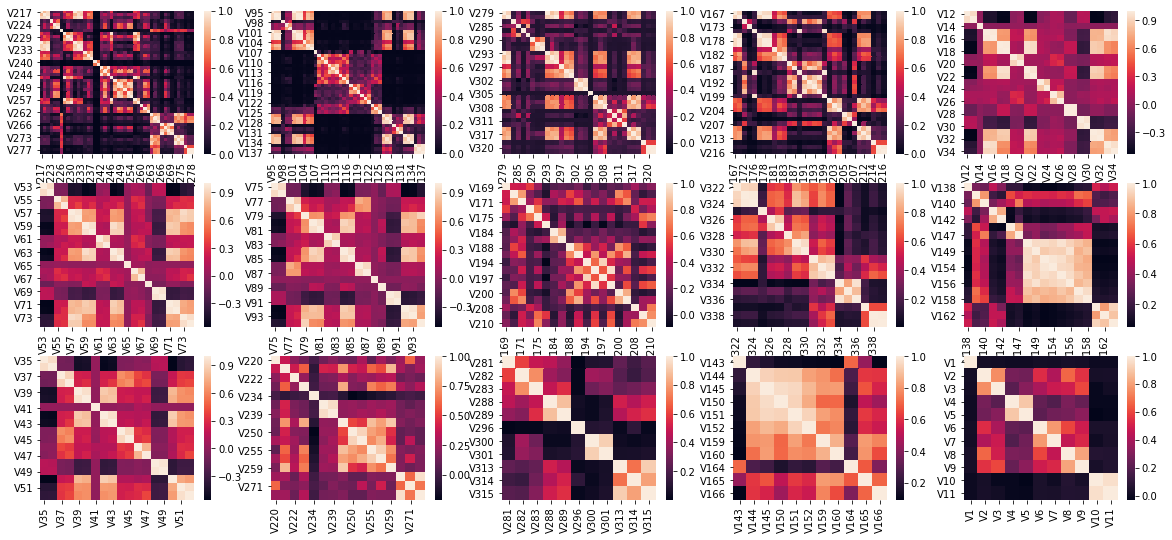

In [9]:
plt.rcParams['figure.figsize'] = 20, 9
plt.figure()
i = 1
for x, y in nan_groups_len:
    cols = nan_groups[x]
    plt.subplot(3, 5, i)
    sns.heatmap(df[cols].corr())
    i = i + 1

### Apply PCA to groups

Create new dataframe with columns which explain the most variance

In [10]:
def create_group_pca_df(df, nan_groups, group):
    pca = PCA()
    
    pca.fit(df[nan_groups[group]].dropna())
    
    components_to_keep_idx = np.cumsum(pca.explained_variance_ratio_) < 0.999

    pca_array = pca.transform(df[nan_groups[group]].dropna())

    pca_array = pca_array[:, components_to_keep_idx]

    new_columns = ['group_' + str(group) + '_pca_' + str(x) for x in range(pca_array.shape[1])]

    new_group_df = pd.DataFrame(data=pca_array, columns=new_columns, index=df[nan_groups[group]].dropna().index)
    
    return pca, new_group_df

In [11]:
group = nan_groups_len[0][0]

In [12]:
pca_models = {}
new_df = pd.DataFrame(index = df.index)

pca_models[group], group_df = create_group_pca_df(df, nan_groups, group)

new_df = new_df.merge(group_df,
                      how='left',
                      left_index=True,
                      right_index=True)

Visualize explained variance

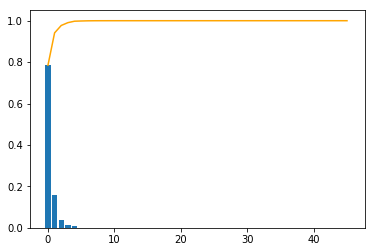

In [13]:
plt.rcParams['figure.figsize'] = 6, 4

plt.bar(range(len(pca_models[group].components_)), pca_models[group].explained_variance_ratio_)
plt.plot(range(len(pca_models[group].components_)), np.cumsum(pca_models[group].explained_variance_ratio_),'orange')

This shows that in the first group, only 5 features are needed to explain essentially all of the variance! This means we can reduce the number of columns from 46 to 5!

In [15]:
pca_models = {}
new_df = pd.DataFrame(index = df.index)

num_original_columns = 0

for group, y in nan_groups_len:
    pca_models[group], group_df = create_group_pca_df(df, nan_groups, group)
    
    new_df = new_df.merge(group_df,
                          how='left',
                          left_index=True,
                          right_index=True)
    
    num_original_columns += y
    
    print('Original Num of Columns = ' + str(y) + ' , New Num of Columns = ' + str(len(group_df.columns)))
    
print('Total Original Num of Columns = ' + str(num_original_columns) + ' , Total New Num of Columns = ' + str(len(new_df.columns)))

Original Num of Columns = 46 , New Num of Columns = 6
Original Num of Columns = 43 , New Num of Columns = 6
Original Num of Columns = 32 , New Num of Columns = 7
Original Num of Columns = 31 , New Num of Columns = 6


C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Original Num of Columns = 23 , New Num of Columns = 17


C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Original Num of Columns = 22 , New Num of Columns = 18


C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Original Num of Columns = 20 , New Num of Columns = 17


C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Original Num of Columns = 19 , New Num of Columns = 2
Original Num of Columns = 18 , New Num of Columns = 5


C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Original Num of Columns = 18 , New Num of Columns = 2


C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Original Num of Columns = 18 , New Num of Columns = 15


C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Original Num of Columns = 16 , New Num of Columns = 4


C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Original Num of Columns = 11 , New Num of Columns = 2
Original Num of Columns = 11 , New Num of Columns = 2


C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Original Num of Columns = 11 , New Num of Columns = 9
Total Original Num of Columns = 339 , Total New Num of Columns = 118


In [17]:
print('Number of columns reduced = ' + str(num_original_columns - len(new_df.columns)))

Number of columns reduced = 221


## Pre-process Data

In [18]:
vesta_columns = [x for x in df.columns if x[0]=='V']  

In [19]:
# Set missing values for vesta columns
for feature in vesta_columns:
    df[feature] = df[feature].fillna(-999) 

In [20]:
# Set missing values for vesta columns
for feature in new_df.columns:
    new_df[feature] = new_df[feature].fillna(-999) 

## Modelling

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

### Original Data

Model Fit Processing Time : 34.57627272605896


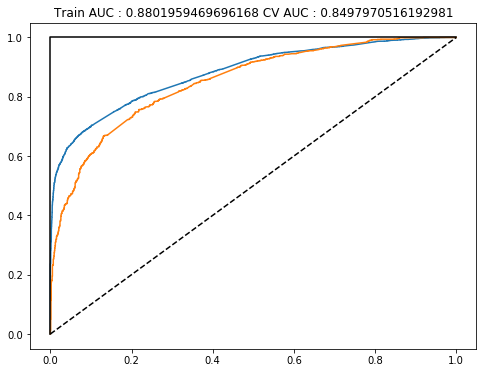

In [23]:
# Split test and train parts of dataframe
P_train = df[:len(train_index)][vesta_columns]
P_test = df[len(train_index):][vesta_columns]

# Downsample negative values
positive = P_train[y_train==1].index
negative = P_train[y_train==0].sample(frac=0.04).index

# Combine indicies
downsample_train_idx = positive.append(negative)

# Create new training set
X = P_train.loc[downsample_train_idx].sort_values(by='TransactionID')
y = y_train.loc[X.index]

# Create training and cross validation data set
# Cross validation set will be last 20% of the data, split by date
end_idx = round(len(X)*0.8)
X_train_cv = X[:end_idx]
y_train_cv = y[:end_idx]
X_cv = X[end_idx:]
y_cv = y[end_idx:]

# Define gradient boosting classifier
gbc = GradientBoostingClassifier(max_depth=4,
                                 n_estimators=200,
                                 learning_rate=0.05,
                                 subsample=0.9,
                                 max_features='auto')

start = time.time()
gbc.fit(X_train_cv, y_train_cv)
print('Model Fit Processing Time : ' + str(time.time()-start))
y_predict = gbc.predict(X_train_cv)
y_train_score = gbc.predict_proba(X_train_cv)
y_cv_score = gbc.predict_proba(X_cv)

fpr, tpr, _ = roc_curve(y_train_cv, y_train_score[:,1])
train_auc = auc(fpr, tpr)
plt.rcParams['figure.figsize'] = 8, 6
plt.plot(fpr, tpr, label='Train')

fpr, tpr, _ = roc_curve(y_cv, y_cv_score[:,1])
cv_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='CV')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 0, 1], [0, 1, 1], 'k')
plt.title('Train AUC : ' + str(train_auc) + ' CV AUC : ' + str(cv_auc))
plt.show()

### PCA Transformed

Model Fit Processing Time : 16.63639736175537


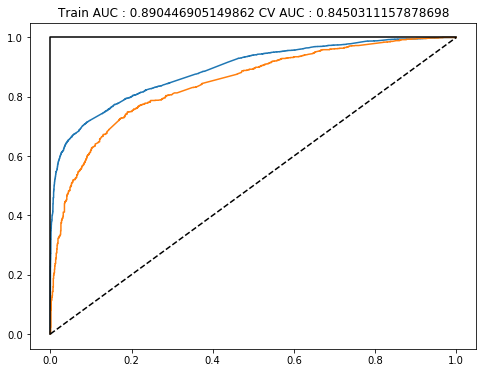

In [24]:
# Split test and train parts of dataframe
P_train = new_df[:len(train_index)]
P_test = new_df[len(train_index):]

# Downsample negative values
positive = P_train[y_train==1].index
negative = P_train[y_train==0].sample(frac=0.04).index

# Combine indicies
downsample_train_idx = positive.append(negative)

# Create new training set
X = P_train.loc[downsample_train_idx].sort_values(by='TransactionID')
y = y_train.loc[X.index]

# Create training and cross validation data set
# Cross validation set will be last 20% of the data, split by date
end_idx = round(len(X)*0.8)
X_train_cv = X[:end_idx]
y_train_cv = y[:end_idx]
X_cv = X[end_idx:]
y_cv = y[end_idx:]

# Define gradient boosting classifier
gbc = GradientBoostingClassifier(max_depth=4,
                                 n_estimators=200,
                                 learning_rate=0.05,
                                 subsample=0.9,
                                 max_features='auto')

start = time.time()
gbc.fit(X_train_cv, y_train_cv)
print('Model Fit Processing Time : ' + str(time.time()-start))
y_predict = gbc.predict(X_train_cv)
y_train_score = gbc.predict_proba(X_train_cv)
y_cv_score = gbc.predict_proba(X_cv)

fpr, tpr, _ = roc_curve(y_train_cv, y_train_score[:,1])
train_auc = auc(fpr, tpr)
plt.rcParams['figure.figsize'] = 8, 6
plt.plot(fpr, tpr, label='Train')

fpr, tpr, _ = roc_curve(y_cv, y_cv_score[:,1])
cv_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='CV')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 0, 1], [0, 1, 1], 'k')
plt.title('Train AUC : ' + str(train_auc) + ' CV AUC : ' + str(cv_auc))
plt.show()

## Conclusion
This shows that with PCA the model trains in almost 50% of the time, and has nearly the same accuracy as using the original data.

When using the full dataset this will result in being able to train the model significantly faster. In addition, it reduces the number of correlated columns.

The model does overfit the PCA transformed data, likely because there are less columns.

CV AUC (Original)        = 0.84797

CV AUC (PCA Transformed) = 0.84503

CV AUC Difference        = 0.00294

Training Time (Original)        = 34.576 s

Training Time (PCA Transformed) = 16.636 s

Training Time Difference        = 17.940 s

Training Time Reduction (%)    = 48.1 %